In [ ]:
#| default_exp lcssm

# Log-Concave State Space Models

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jrn


A log-concave state space model is a partially gaussian state space model where the distribution of states $X_t$ is gaussian, but the (conditional) distribution of observations $Y_t$ is non-gaussian, but log-concave in signals $S_t = B_tX_t$ for a matrix $B_t$.

That is we consider 

$$
\begin{align*}
    X_0 &\sim \mathcal N(x_0, \Sigma_0)\\
    X_{t + 1} &= A_t X_t + \varepsilon_{t + 1}\\
    \varepsilon_{t} &\sim \mathcal N(0, \Sigma_t)\\
    Y_t | X_t &\sim Y_t | S_t \sim p(y_t|s_t)
\end{align*}
$$
where the conditional density $p(y_t|s_t)$ is **log-concave**, i.e. $\log p(y_t|s_t)$ is concave in $s_t$. 


::: {.callout-note}
# Implementation Detail
> dependency on parameters

To facilitate faster evaluation we split the implementation of $p(y_t|s_t)$ into two steps: 
- given $s_t$ compute a Pytree of parameters $\xi_t(s_t)$ 
- given $\xi_t$ compute $p(y_t|s_t)$

The first step allows for vectorization which we want to do as much as possible outside of the `tfd` calls.

As an example consider the univariate example of a negative binomial distribution with $\log$ link and constant overdispersion parameter $r$, i.e. $Y_t | X_t \sim \text{NegBinom}(\mu = \exp(X_t), r)$. In this case $S_t = X_t$ and $\xi_t(s_t) = (r, s_t)$.
:::

## Simulation

As the states are gaussian, we can first simulate the states $X$ and then, conditional on them, calculate $S$ and $\xi$.

In [ ]:
#| exporti

from jaxtyping import Float, Array, PRNGKeyArray
from isssm.glssm import log_probs_x

In [ ]:
#| exporti

from isssm.glssm import simulate_states
from jax import vmap
import jax.numpy as jnp
import jax.random as jrn
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN,
    NegativeBinomial as NBinom,
    Poisson
)

from jax import lax

# matmul with $(A_t)_{t}$ and $(X_t)_{t}$
mm_time = vmap(jnp.matmul, (0, 0))
# matmul with $(A_t)_{t}$ and $(X^i_t)_{i,t}$
mm_time_sim = vmap(mm_time, (None, 0))

In [ ]:
# | export
def simulate_lcssm(
    x0: Float[Array, "m"],  # initial state
    A: Float[Array, "n m m"],  # transition matrices
    Sigma: Float[Array, "n+1 m m"],  # innovation covariances
    B: Float[Array, "n+1 p m"],  # signal matrices
    dist,  # observation distribution
    xi, # observation parameters
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N n+1 p"]
]:  # simulated states and observations
    key, subkey = jrn.split(key)
    X = simulate_states(x0, A, Sigma, N, subkey)
    S = mm_time_sim(B, X)

    Y = dist(S, xi).sample(seed=subkey)

    return X, Y

## Negative Binomial Common Factor Model

As an example consider a variant of the [common factor model](01_example_models.ipynb) where observations now follow a conditional negative binomial distribution, i.e. $$Y_t^i| X_{t} \sim \text{NegBinom}(\exp((BX_t)_i), r)$$ for $i = 1,2$, conditionally independent.

In [ ]:
# | export

def nb_lcssm(
    x0: Float[Array, "m"], # initial state
    A: Float[Array, "n m m"], # transition matrices
    Sigma: Float[Array, "n+1 m m"], # innovation covariances
    B: Float[Array, "n+1 p m"], # signal matrices
    r: Float, # overdispersion parameter
): # negative binomial LCSSM
    """Create a negative binomial LCSSM with constant overdispersion"""

    np1,m, _ = B.shape
    xi = jnp.full((np1, m), r)

    def dist_nb(log_mu, xi):
        mu = jnp.exp(log_mu)
        return NBinom(r, probs=mu / (xi + mu))

    return x0, A, Sigma, B, dist_nb, xi

In [ ]:
#| export
def poisson_lcssm(
    x0: Float[Array, "m"], # initial state
    A: Float[Array, "n m m"], # transition matrices
    Sigma: Float[Array, "n+1 m m"], # innovation covariances
    B: Float[Array, "n+1 p m"], # signal matrices
): # Poisson LCSSM
    """Create a negative binomial LCSSM with constant overdispersion"""

    np1,m, _ = B.shape

    def dist_pois(log_mu, xi):
        return Poisson(log_rate=log_mu)

    return x0, A, Sigma, B, dist_pois, jnp.empty((np1, m))

We use the same set of parameters for this model: the transition matrices $A_t$ are the identity matrix and the signal matrices $B_t$ are $\begin{pmatrix}
    1 & 0 & 1 \\ 0 & 1 & 1
\end{pmatrix}$.

In [ ]:
m, p, n = 3, 2, 100
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, dist, xi = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(X, ), (Y,) = simulate_lcssm(x0, A, Sigma, B, dist, xi, N, subkey)

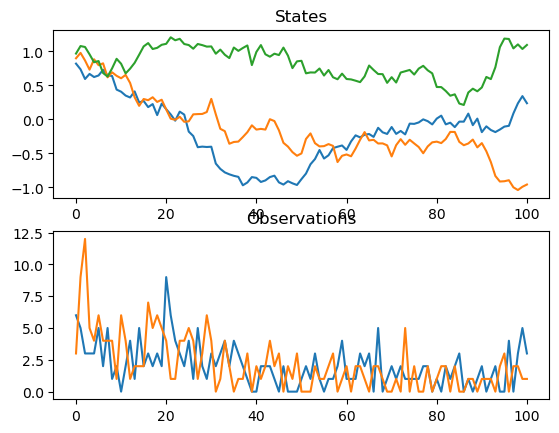

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("States")
ax2.set_title("Observations")

ax1.plot(X)
ax2.plot(Y)

plt.show()

Notice that the observations are now integer valued.

## joint density

To evaluate the joint density we use the same approach as described in [00_glssm#Joint Density], replacing the observation density with the LCSSM one.

In [ ]:
#| export

def log_probs_y(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    B: Float[Array, "n+1 p m"],  # signal matrices
    dist,  # observation distribution
    xi, # observation parameters
):
    s = (B @ x[:,:,None])[:,:,0]
    return dist(s, xi).log_prob(y).sum(axis=1)

def log_prob(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    x0: Float[Array, "m"],  # initial mean
    A: Float[Array, "n m m"],  # transition matrices
    Sigma: Float[Array, "n+1 m m"],  # innovation covariances
    B: Float[Array, "n+1 p m"],  # signal matrices
    dist,  # observation distribution
    xi, # observation parameters
):
    px = log_probs_x(x, x0, A, Sigma).sum()
    py = log_probs_y(x, y, B, dist, xi).sum()
    return px + py

In [ ]:
log_prob(X, Y, x0, A, Sigma, B, dist, xi)

Array(-65.55389508, dtype=float64)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()